In [1]:
import re
import pandas as pd
import numpy as np
import datetime as dt
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
%matplotlib inline
sns.set()
sns.set_style({'ytick.bottom': True})
from sklearn.model_selection import cross_val_score


In [2]:
pd.options.display.max_rows = 10

In [3]:
def TrainValTest(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/test split, 
    then further split into training, validation, and test sets (60/20/20).
    '''
    
    # perform train/test split
    X_train_val, X_test, y_train_val, y_test = \
        train_test_split(X, y, test_size=0.2, random_state=42)
    #split training set again
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=3)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [4]:
with open('data/project_2_basecase.pkl', 'rb') as picklefile:
    df_base = pickle.load(picklefile)

#### Bin low-frequency genres to "Other" category

In [7]:
df_base['genre'] = df_base.genre.apply(lambda x: ''.join(x.split(',')[:2]))
genrecounts = df_base.genre.value_counts()
othergenres = list(genrecounts[genrecounts<=60].index)
df_base['genre'] = df_base['genre'].replace(othergenres, 'Other')
df_base.drop('style', axis=1, inplace=True)
df_base=pd.get_dummies(df_base)

In [8]:
X_train, X_val, X_test, y_train, y_val, y_test = \
TrainValTest(df_base.drop('median',axis=1), df_base['median'])

In [9]:
lm = LinearRegression()
lm.fit(X_train, y_train)
print("Training score: ",lm.score(X_train, y_train),"\nValidation Score: ",lm.score(X_val,y_val))

Training score:  0.939467323869293 
Validation Score:  0.9036869766117189


Wow that's high! I wonder why?

In [16]:
# mostly attributable to lowest, highest, and rating features
sorted(list(zip(lm.coef_, X_train.columns)), reverse=True)

[(0.9250883232352561, 'lowest'),
 (0.6022930423721885, 'genre_Electronic Hip Hop'),
 (0.5340347082565168, 'genre_Other'),
 (0.527325656414518, 'format_CDr'),
 (0.47126390093642034, 'genre_Electronic Reggae'),
 (0.37460631859308363, 'country_Canada'),
 (0.35930792869497197, 'genre_Electronic Rock'),
 (0.3570586407594417, 'genre_Reggae'),
 (0.3460367374442034, 'format_CD'),
 (0.3459092123211889, 'country_Sweden'),
 (0.2818880467696525, 'genre_Hip Hop Funk / Soul'),
 (0.27168759959702565, 'rating'),
 (0.26634159488522774, 'country_Europe'),
 (0.2662045070131954, 'comment_num'),
 (0.26157993507431754, 'genre_Jazz'),
 (0.25928554330301073, 'country_Belgium'),
 (0.25522402958824897, 'format_Vinyl'),
 (0.2243900757833744, 'country_UK & Europe'),
 (0.20466208556596843, 'highest'),
 (0.18342298148731112, 'genre_Rock'),
 (0.15686086261320814, 'genre_Jazz Funk / Soul'),
 (0.14449490603448045, 'country_Italy'),
 (0.10632169278032938, 'genre_Hip Hop'),
 (0.04962539366643635, 'country_France'),
 (0.

The "lowest" and "highest" features are giving our model too much information about the median--if you have 

In [9]:
lm2= LinearRegression()
lm2.fit(X_train.drop(['highest','lowest'],axis=1), y_train)
print("Training score: ",lm2.score(X_train.drop(['highest','lowest'], axis=1), y_train),"\nValidation Score: ",lm2.score(X_val.drop(['highest','lowest'], axis=1),y_val))

Training score:  0.5107146837538736 
Validation Score:  0.6303993246414166


In [10]:
cross_val_score(lm2, df_base.drop(['median', 'highest','lowest'],axis=1),df_base['median'], cv=5, scoring = 'r2')

array([0.45151665, 0.47897333, 0.48348061, 0.46494907, 0.58771434])

#### maybe the outliers are making this too hard

In [21]:
df2=df_base[(df_base['median']<200)&(df_base['median']>0.15)]

In [47]:
X2_train, X2_val, X2_test, y2_train, y2_val, y2_test = \
TrainValTest(df2.drop('median',axis=1), df2['median'])

In [48]:
lm2= LinearRegression()
lm2.fit(X2_train.drop(['highest','lowest'],axis=1), y2_train)
print("Training score: ",lm2.score(X2_train.drop(['highest','lowest'], axis=1), y2_train),"\nValidation Score: ",lm2.score(X2_val.drop(['highest','lowest'], axis=1),y2_val))

Training score:  0.5049143661313207 
Validation Score:  0.6029416375783858


In [49]:
np.mean(cross_val_score(lm2, df2.drop(['median', 'highest','lowest'],axis=1),df2['median'], cv=5, scoring = 'r2'))

0.5264008802454783

not bad...

In [50]:
sorted(list(zip(lm2.coef_, X2_train.columns)), reverse=True)[:15]

[(4.594117147924629, 'format_CDr'),
 (3.5671886713105607, 'country_Germany'),
 (2.684254534081385, 'genre_Hip Hop'),
 (2.4358417985892524, 'country_Spain'),
 (2.4252998109605683, 'genre_Other'),
 (2.4042062125133077, 'want_num'),
 (2.2075694922263276, 'country_UK & Europe'),
 (1.9943577007429933, 'num_for_sale'),
 (1.8660046891047752, 'format_Other'),
 (1.2960070864761342, 'genre_Electronic Jazz'),
 (0.9008771298890508, 'genre_Electronic Pop'),
 (0.8315541370531605, 'country_Japan'),
 (0.7722027165034512, 'genre_Jazz Funk / Soul'),
 (0.7700193612841675, 'genre_Jazz'),
 (0.689755257434308, 'genre_Pop')]

In [51]:
alphavec = np.linspace(10, 100, 90)
ridge_model = RidgeCV(alphavec, cv=5)
ridge_model.fit(X2_train.drop(['highest','lowest'],axis=1), y2_train)


RidgeCV(alphas=array([ 10.        ,  11.01123596,  12.02247191,  13.03370787,
        14.04494382,  15.05617978,  16.06741573,  17.07865169,
        18.08988764,  19.1011236 ,  20.11235955,  21.12359551,
        22.13483146,  23.14606742,  24.15730337,  25.16853933,
        26.17977528,  27.19101124,  28.20224719,  29.21348315,
        30.2247191 ,  31.23595506,  32.24719101,  33.25842697,
        34.26966292,  35.28089888,  36.29213483,  37.30337079,
        38...
        74.71910112,  75.73033708,  76.74157303,  77.75280899,
        78.76404494,  79.7752809 ,  80.78651685,  81.79775281,
        82.80898876,  83.82022472,  84.83146067,  85.84269663,
        86.85393258,  87.86516854,  88.87640449,  89.88764045,
        90.8988764 ,  91.91011236,  92.92134831,  93.93258427,
        94.94382022,  95.95505618,  96.96629213,  97.97752809,
        98.98876404, 100.        ]),
        cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
        store_cv_values=False)

In [63]:
ridge_model.score(X2_val.drop(['highest','lowest'], axis=1), y2_val)

0.6039850432747542

#### Can we get away with no information about price at all?

In [30]:
with open('data/project_2_styletags.pkl', 'rb') as picklefile:
    df_noprices = pickle.load(picklefile)

In [31]:
#df_noprices=df_noprices[(df_noprices['median']<100)&(df_noprices['median']>0.15)]

In [32]:
X3_train, X3_val, X3_test, y3_train, y3_val, y3_test = \
TrainValTest(df_noprices.drop('median',axis=1), df_noprices['median'])

In [33]:
lm3= LinearRegression()
lm3.fit(X3_train, y3_train)
print("Training score: ",lm3.score(X3_train, y3_train),"\nValidation Score: ",lm3.score(X3_val,y3_val))

Training score:  0.30523870356004734 
Validation Score:  0.38096360942657576


In [34]:
np.mean(cross_val_score(lm3, df_noprices.drop('median',axis=1), df_noprices['median'], cv=5, scoring='r2'))

0.31902836886688063

### OK, let's see if we can do better!

In [66]:
df3 = df_noprices.copy()
df3['want_have_ratio'] = df3['want_num']/df2['have_num']
df3['want_have_ratio'].replace(np.inf, 0, inplace=True)
df3['want_have_ratio'].replace(np.nan, 0,inplace=True)

In [67]:
X4_train, X4_val, X4_test, y4_train, y4_val, y4_test = \
TrainValTest(df3.drop('median',axis=1), df3['median'])

In [68]:
lm4= LinearRegression()
lm4.fit(X4_train, y4_train)
print("Training score: ",lm4.score(X4_train, y4_train),"\nValidation Score: ",lm4.score(X4_val,y4_val))

Training score:  0.3311356183264471 
Validation Score:  0.42247590529705903


In [69]:
np.mean(cross_val_score(lm4, df3.drop('median',axis=1), df3['median'], cv=5,scoring='r2'))

0.3397092022168965

In [70]:
sorted(list(zip(lm4.coef_, X4_train.columns)),reverse=True)

[(5.971370486080959, 'country_Japan'),
 (5.821300059397675, 'format_Other'),
 (2.6863899482033027, 'country_Australia'),
 (2.5771588245744663, 'rating'),
 (2.103861336550023, 'Gabber'),
 (2.0934021448641342, 'country_Switzerland'),
 (1.5937937981484616, 'Jungle'),
 (1.4223923302812898, 'Non-Music'),
 (1.2237145134026444, 'Noise'),
 (1.1825607299962204, 'want_have_ratio'),
 (1.1289038337247934, 'Classical'),
 (1.0705618611499625, 'Experimental'),
 (1.0571948868739605, 'format_CDr'),
 (1.004819044318493, 'Rock'),
 (0.9402327593131624, 'country_Sweden'),
 (0.92878297976167, 'New Wave'),
 (0.8615830701400145, 'Psychedelic Rock'),
 (0.8528928589124305, 'Punk'),
 (0.810848047448805, 'Acid'),
 (0.7966609244633538, 'Synth-pop'),
 (0.764946302439288, 'Blues'),
 (0.7363445340374248, 'Italodance'),
 (0.7147425944001823, 'country_Other'),
 (0.7110688742949256, 'Jazz'),
 (0.582138457561124, 'comment_num'),
 (0.5792230920243508, 'Industrial'),
 (0.5700595429391084, 'Funk'),
 (0.5688285711182198, 'Br

In [71]:
df4=df3.copy()
df4['inv_for_sale'] = 1/df4['num_for_sale']
df4['inv_for_sale'].replace(np.inf, 0,inplace=True)

In [72]:
X5_train, X5_val, X5_test, y5_train, y5_val, y5_test = \
TrainValTest(df4.drop('median',axis=1), df4['median'])

In [73]:
lm5= LinearRegression()
lm5.fit(X5_train, y5_train)
print("Training score: ",lm5.score(X5_train, y5_train),"\nValidation Score: ",lm5.score(X5_val,y5_val))

Training score:  0.33727141398430094 
Validation Score:  0.4296893115580549


In [74]:
np.mean(cross_val_score(lm5, df4.drop('median',axis=1), df4['median'], cv=5,scoring='r2'))

0.34673073802811016

In [75]:
df5=df4.copy()
df5['inv_have_num'] = 1/df5['have_num']
df5['inv_have_num'].replace(np.inf, 0,inplace=True)

In [76]:
X6_train, X6_val, X6_test, y6_train, y6_val, y6_test = \
TrainValTest(df5.drop('median',axis=1), df5['median'])


In [77]:
lm6= LinearRegression()
lm6.fit(X6_train, y6_train)
print("Training score: ",lm6.score(X6_train, y6_train),"\nValidation Score: ",lm6.score(X6_val,y6_val))

Training score:  0.3398697179374779 
Validation Score:  0.4320846373759466


In [78]:
np.mean(cross_val_score(lm6, df5.drop('median',axis=1), df5['median'], cv=5,scoring='r2'))

0.347778732636383

In [79]:
df6=df5.copy()
df6['rating_scaled'] = df6['rating']*df6['num_ratings']

X7_train, X7_val, X7_test, y7_train, y7_val, y7_test = \
TrainValTest(df6.drop('median',axis=1), df6['median'])

In [80]:
lm7= LinearRegression()
lm7.fit(X7_train, y7_train)
print("Training score: ",lm7.score(X7_train, y7_train),"\nValidation Score: ",lm7.score(X7_val,y7_val))

Training score:  0.343074056826871 
Validation Score:  0.4301519802818574


In [81]:
np.mean(cross_val_score(lm7, df6.drop('median',axis=1), df6['median'], cv=5,scoring='r2'))

0.3499626784079949

In [82]:
df7=df6.copy()
df7['inv_rating_scaled'] = 1/(df7['rating']*df7['num_ratings'])
df7['inv_rating_scaled'].replace(np.inf, 0,inplace=True)

X8_train, X8_val, X8_test, y8_train, y8_val, y8_test = \
TrainValTest(df7.drop('median',axis=1), df7['median'])


In [83]:
lm8= LinearRegression()
lm8.fit(X8_train, y8_train)
print("Training score: ",lm8.score(X8_train, y8_train),"\nValidation Score: ",lm8.score(X8_val,y8_val))

Training score:  0.3430852151695224 
Validation Score:  0.4301414054237418


In [84]:
np.mean(cross_val_score(lm8, df7.drop('median',axis=1), df7['median'], cv=5,scoring='r2'))

0.3499615252210169

In [85]:
poly=PolynomialFeatures()

X9_train=poly.fit_transform(X8_train)
X9_val = poly.transform(X8_val)
X9_test = poly.transform(X8_test)

scaler = StandardScaler()
X9_tr_sc = scaler.fit_transform(X9_train)
X9_val_sc = scaler.transform(X9_val)
X9_test_sc = scaler.transform(X9_test)

In [41]:
poly_lm8= LinearRegression()
poly_lm8.fit(X9_tr_sc, y8_train)
print("Training score: ",poly_lm8.score(X9_tr_sc, y8_train),"\nValidation Score: ",poly_lm8.score(X9_val,y8_val))

Training score:  0.7099890984558402 
Validation Score:  -2.1305545802027074e+31


In [42]:
lasso_model = LassoCV(cv=5)
lasso_model.fit(X9_tr_sc, y8_train)

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 238.98914813739248, tolerance: 199.28064250181106
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 225.20286547858268, tolerance: 199.28064250181106
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 223.7159834865015, tolerance: 199.28064250181106
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective d

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 365.2320606849389, tolerance: 182.9700911545351
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 376.5773810020182, tolerance: 182.9700911545351
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 307.1754896081984, tolerance: 182.9700911545351
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did no

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 366.7021679392783, tolerance: 188.44040695472165
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 522.4083829971496, tolerance: 188.44040695472165
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1655.8829025097657, tolerance: 188.44040695472165
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective di

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 698.5636827282142, tolerance: 186.5696125835239
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 880.0142293232493, tolerance: 186.5696125835239
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 798.7518672076985, tolerance: 186.5696125835239
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did no

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

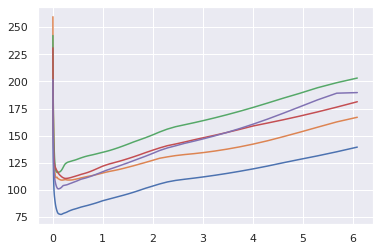

In [43]:
plt.plot(lasso_model.alphas_, lasso_model.mse_path_)

In [83]:
sorted(list(zip(lasso_model.coef_, poly.get_feature_names(X8_train.columns))),reverse=True)

[(3.456645719670963, 'rating want_num'),
 (2.59501321247965, 'link_num want_have_ratio'),
 (1.3869082340505217, 'want_num inv_for_sale'),
 (1.158411226664472, 'want_have_ratio rating_scaled'),
 (0.8842717467926604, 'num_ratings want_have_ratio'),
 (0.8271302637017305, 'want_num Indie Rock'),
 (0.7769084516501096, 'inv_have_num rating_scaled'),
 (0.7423841644216214, 'want_num format_CDr'),
 (0.706267815751362, 'rating^2'),
 (0.5517071550850854, 'format_Other Hard Trance'),
 (0.528894686318862, 'comment_num want_have_ratio'),
 (0.5228739254016703, 'country_Belgium Non-Music'),
 (0.5032560075671217, 'country_US want_have_ratio'),
 (0.487926749765403, 'rating inv_for_sale'),
 (0.47990544780589023, 'Reggae want_have_ratio'),
 (0.4678126563900108, ' want_have_ratio'),
 (0.4665762260754584, 'want_num country_France'),
 (0.45279974101128495, 'Other_Style want_have_ratio'),
 (0.4335402352228653, 'Rock want_have_ratio'),
 (0.4270662616293774, 'Funk want_have_ratio'),
 (0.4265635702498312, 'want_

In [1]:
pd.describe_option()

NameError: name 'pd' is not defined

In [81]:
lasso_model.score(X9_test_sc,y8_test)

0.39236867576003437

In [60]:
np.mean(cross_val_score(lasso_model, X9_tr_sc, y8_train, cv=5,scoring='r2'))

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 198.77457580389455, tolerance: 163.6808309497272
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 252.66493825311773, tolerance: 163.6808309497272
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 232.55703401134815, tolerance: 163.6808309497272
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 224.50732929073274, tolerance: 159.69633869731405
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 311.7137056895299, tolerance: 159.69633869731405
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 360.2673550519394, tolerance: 159.69633869731405
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective di

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2506.463300007861, tolerance: 154.95896738880975
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2562.240710768616, tolerance: 154.95896738880975
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2903.8950260413694, tolerance: 154.95896738880975
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective di

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2699.5486753457226, tolerance: 156.1288639707728
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2617.951994903153, tolerance: 156.1288639707728
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2258.7547379374155, tolerance: 156.1288639707728
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did 

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 578.3661859985441, tolerance: 159.91730193054792
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 668.2278166839387, tolerance: 159.91730193054792
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 809.6571272362489, tolerance: 159.91730193054792
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 579.2751396039966, tolerance: 147.97222766417346
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 368.8469459376065, tolerance: 147.97222766417346
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 653.5011962278513, tolerance: 147.97222766417346
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 193.6902026378084, tolerance: 150.5866673026393
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 292.84597284987103, tolerance: 150.5866673026393
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 262.4638552843826, tolerance: 150.5866673026393
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did n

KeyboardInterrupt: 

/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


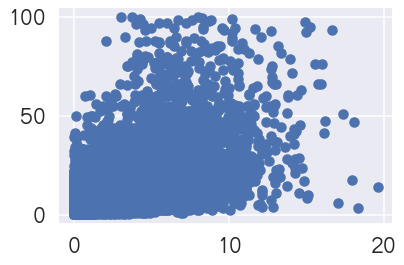

In [217]:
plt.scatter(np.log10(df7['want_num']*df7['want_have_ratio'])**2,df7['median'])

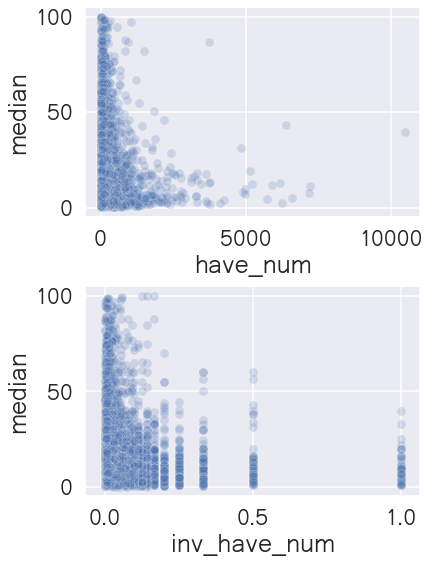

In [295]:
fig, axs = plt.subplots(2,1, figsize=(6,9))
axs[0] = sns.scatterplot(df7['have_num'],df7['median'], alpha = 0.2, ax=axs[0])
axs[0].set_ylabel("")
axs[1] = sns.scatterplot(df7['inv_have_num'], df7['median'], alpha=0.2, ax=axs[1])
fig.subplots_adjust(hspace=.33)


In [86]:
df8=df7.copy()
df8['sqrt_rating_want'] = np.sqrt(df8['rating']*df8['want_num'])
df8['inv_rating_scaled'].replace(np.inf, 0,inplace=True)

X10_train, X10_val, X10_test, y10_train, y10_val, y10_test = \
TrainValTest(df8.drop('median',axis=1), df8['median'])

In [87]:
lm9 = LinearRegression()
lm9.fit(X10_train, y10_train)
print("Training score: ",lm9.score(X10_train, y10_train),\
      "\nValidation Score: ",lm9.score(X10_val,y10_val))

Training score:  0.3792377372915178 
Validation Score:  0.4452812355368857


In [88]:
np.mean(cross_val_score(lm9, df8.drop('median',axis=1), df8['median'], cv=5,scoring='r2'))

0.38223052532856744

In [89]:
df9=df8.copy()
df9['sqrt_wantsq/have'] = np.sqrt(df7['want_num']*df7['want_have_ratio'])

X11_train, X11_val, X11_test, y11_train, y11_val, y11_test = \
TrainValTest(df9.drop('median',axis=1), df9['median'])


In [90]:
lm10 = LinearRegression()
lm10.fit(X11_train, y11_train)
print("Training score: ",lm10.score(X11_train, y11_train),\
      "\nValidation Score: ",lm10.score(X11_val,y11_val))

Training score:  0.4070523735087206 
Validation Score:  0.45471314487274084


In [91]:
df10=df9.copy()
df10['sqrt_linknum_by_want/have'] = np.sqrt(df10['link_num']*df10['want_have_ratio'])

X12_train, X12_val, X12_test, y12_train, y12_val, y12_test = \
TrainValTest(df10.drop('median',axis=1), df10['median'])


In [93]:
lm11 = LinearRegression()
lm11.fit(X12_train, y12_train)
print("Training score: ",lm11.score(X12_train, y12_train),\
      "\nValidation Score: ",lm11.score(X12_val,y12_val))

Training score:  0.42876279825974406 
Validation Score:  0.45869284871539434


In [99]:
alphavec=np.linspace(75,90, 90)
lm12 = RidgeCV(alphas=alphavec, store_cv_values=True)
lm12.fit(X12_train, y12_train)
print("Training score: ",lm12.score(X12_train, y12_train),\
      "\nValidation Score: ",lm12.score(X12_val,y12_val))

Training score:  0.42742285707436445 
Validation Score:  0.4609372238219853


In [124]:
lm12.alpha_

80.3932584269663

In [126]:
X_train_f, X_test_f, y_train_f, y_test_f =train_test_split(df10.drop('median',axis=1), df10['median'], test_size=0.2, random_state=42)

In [128]:
lm11.fit(X_train_f, y_train_f)
print("Training score: ",lm11.score(X_train_f, y_train_f),\
      "\nValidation Score: ",lm11.score(X_test_f,y_test_f))

Training score:  0.4386395437319395 
Validation Score:  0.4319022346050694


(array([160.,  61.,  15.,   8.,   3.,   1.,   0.,   0.,   0.,   1.]),
 array([  1.   ,  17.399,  33.798,  50.197,  66.596,  82.995,  99.394,
        115.793, 132.192, 148.591, 164.99 ]),
 <a list of 10 Patch objects>)

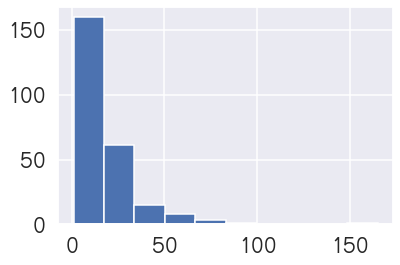

In [273]:
sorted(list(zip(lm11.coef_, X_train_f.columns)),reverse=True)
plt.hist(y_train[X_train['country_Japan']==1])

In [228]:
y_hat = lm11.predict(X_test_f)

# Visualizations

In [229]:
import patsy
import scipy.stats as stats

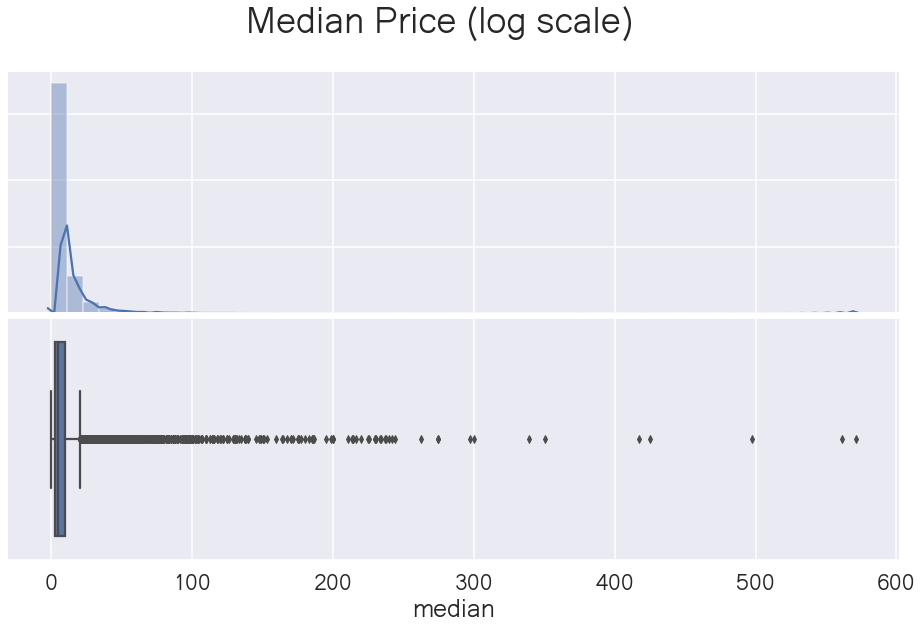

In [112]:
matplotlib.rcParams['font.sans-serif'] = "AnjaliOldLipi"
sns.set_context('talk', font_scale=1.4)
fig, ax =plt.subplots(2,1,'col', figsize = (16,9))
ax[0].tick_params('y', left=False, labelleft=False)
sns.distplot(df_base['median'], ax=ax[0], axlabel=False)
sns.boxplot(df_base['median'], ax=ax[1])
fig.subplots_adjust(wspace=.02, hspace=.02)
plt.suptitle("Median Price (log scale)", fontsize=36, fontweight=5);

plt.savefig('box_target.png')

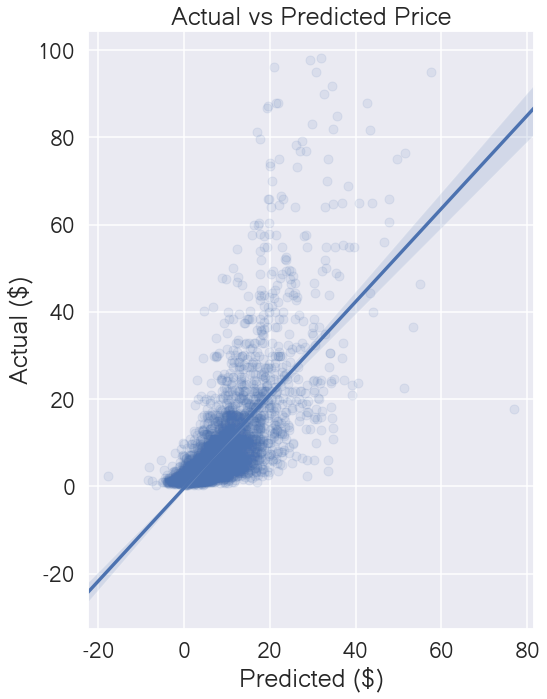

In [253]:
fig = plt.figure(figsize=(8,11))
sns.regplot(y_hat, y_test_f, scatter_kws={'alpha':0.1})
plt.ylabel('Actual ($)')
plt.xlabel('Predicted ($)')
plt.title('Actual vs Predicted Price')
plt.savefig('regplot_wo_outliers_half.png')

In [ ]:
sns.residplot()

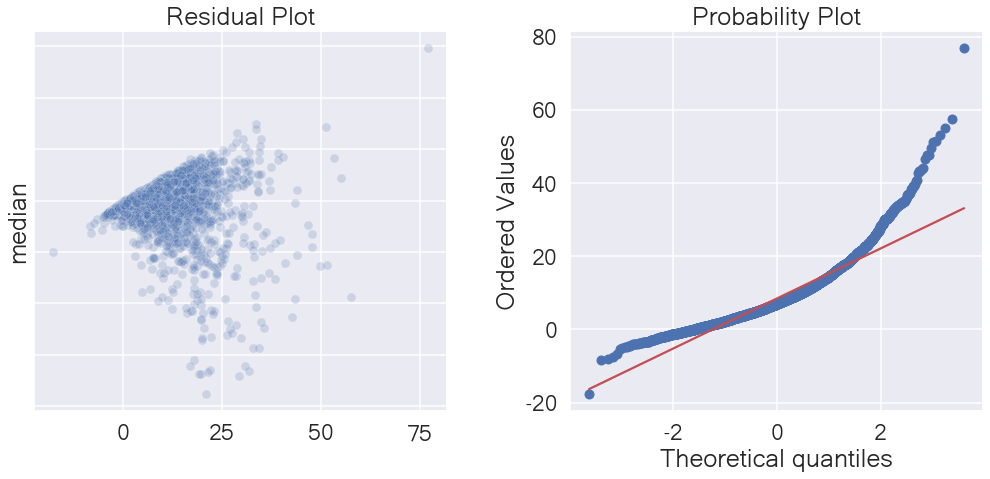

In [256]:
fig, axs = plt.subplots(1,2, figsize=(17,7))
sns.scatterplot(y_hat,(y_hat-y_test_f), ax=axs[0],alpha=0.2)
axs[0].set_title("Residual Plot")
axs[0].tick_params('y', labelleft=False)
plt.subplot(1,2,2)
stats.probplot(y_hat, dist="norm", plot=plt)
ax[1].set_title('Q-Q Plot')
fig.subplots_adjust(wspace=.3)
#fig.savefig('res_and_qq_no_outliers.png')


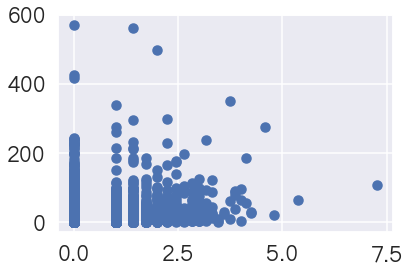

In [250]:
plt.scatter(np.sqrt(df_base['comment_num']), df_base['median'])